# Census Model Deployment to Heroku Using FastAPI

In this project, a simple census dataset is used to create a model pipeline, train it and deploy it to Heroku using FastAPI. The dataset consists of 32,561 entries of different people, each with 14 features (age, education, etc.) and the model infers the salary range of an entry. See the colocated [`README.md`](README.md) for more information.

This notebook is a playground where different data processing and modeling techniques are tested.

You can open this notebook on Google Colab, However, note that you need to upload the dataset to run the notebook there.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mxagar/census_model_deployment_fastapi/blob/master/census_notebook.ipynb)

Table of contents:

- [1. Load and Explore Dataset](#1.-Load-and-Explore-Dataset)
- [2. Data Processing Pipeline](#2.-Data-Processing-Pipeline)
- [3. Model Definition and Training](#3.-Model-Definition-and-Training)
- [4. Model Evaluation](#4.-Model-Evaluation)
- [5. Extra Tests](#5.-Extra-Tests)
    - Use Package
    - Feature Importances
    - ROC Curve
- [6. Bias Analysis](#6.-Bias-Analysis)
- [7. Test Deployed API](#7.-Test-Deployed-API)
    - API: Tests with Local Server
    - API: Tests with Deployed App (Heroku)

## 1. Load and Explore Dataset

In [194]:
import itertools
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [195]:
df = pd.read_csv('./data/census.csv')

In [196]:
df.head()

,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [197]:
# No missing values
# We just need to
# - encode categoricals
# - binarize label/target
# - scale numericals
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlgt           32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [198]:
df.describe()

,age,fnlgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [199]:
# Column names have spaces?
df.columns

Index(['age', ' workclass', ' fnlgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' salary'],
      dtype='object')

In [200]:
# IMPORTANT: We need to do that in production, too!
df = df.rename(columns={col_name: col_name.replace(' ', '') for col_name in df.columns})
df = df.rename(columns={col_name: col_name.replace('-', '_') for col_name in df.columns})

In [201]:
# Column names don't have spaces now
df.columns

Index(['age', 'workclass', 'fnlgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'salary'],
      dtype='object')

In [202]:
# Drop duplicates
# IMPORTANT: We need to do that in production, too!
df = df.drop_duplicates().reset_index(drop=True)

In [203]:
# Some duplicates are removed!
# 32561 -> 32537
df.shape

(32537, 15)

In [205]:
# The targets are not balanced
df.salary.value_counts()

 <=50K    24698
 >50K      7839
Name: salary, dtype: int64

In [207]:
df.salary.unique()

array([' <=50K', ' >50K'], dtype=object)

In [210]:
# Strip/remove the blank space in the categories
categorical_features = list(df.select_dtypes(include = ['object']))
for col in categorical_features:
    df[col] = df[col].str.replace(' ', '')

In [211]:
df.salary.unique()

array(['<=50K', '>50K'], dtype=object)

## 2. Data Processing Pipeline

In [12]:
target = "salary"
categorical_features = list(df.drop(target, axis=1).select_dtypes(include = ['object']))
numerical_features = list(df.select_dtypes(include = ['float', 'int']))

In [13]:
categorical_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [14]:
numerical_features

['age',
 'fnlgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [15]:
len(categorical_features)+len(numerical_features)

14

In [16]:
# Import all necessary tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [17]:
# Define processing for categorical columns
# handle_unknown: label encoders need to be able to deal with unknown labesl!
#categorical_transformer = make_pipeline(
#    SimpleImputer(strategy="constant", fill_value=0),
#    OneHotEncoder(sparse_output=False, handle_unknown="ignore")
#)
# We can use make_pipeline if we don't care about accessing steps later on
# but if we want to access steps, better to use Pipeline!
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

In [18]:
# Define processing for numerical columns
numerical_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [19]:
# Put the 2 tracks together into one pipeline using the ColumnTransformer
# This also drops the columns that we are not explicitly transforming
feature_processor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",  # This drops the columns that we do not transform
)

In [20]:
# Get a list of the columns we used
features = list(itertools.chain.from_iterable([x[2] for x in feature_processor.transformers]))

In [21]:
# Number of features entering the processing pipeline
# before fitting model
len(features)

14

In [22]:
X = df[features]
y = df[target]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, # predictive variables
    y, # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=42, # we are setting the seed here, ALWAYS DO IT!
    stratify=y # if we want to keep class ratios in splits
)

In [24]:
X_train_transformed = feature_processor.fit_transform(X_train)

In [25]:
# Save feature names
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer
# https://stackoverflow.com/questions/54570947/feature-names-from-onehotencoder
cat_names = list(feature_processor.transformers_[1][1]\
    .named_steps['onehot'].get_feature_names_out(categorical_features))
# Remove blank spaces
cat_names = [col.replace(' ', '') for col in cat_names]
num_names = numerical_features
final_feature_names = num_names + cat_names

In [26]:
# Number or final features used to fit the model
len(final_feature_names)

108

In [27]:
target_processor = LabelBinarizer()
y_train_transformed = target_processor.fit_transform(y_train).ravel()

In [28]:
# Save processors and additional data
processing_parameters = dict()
processing_parameters['features'] = features
processing_parameters['target'] = target
processing_parameters['categorical_features'] = categorical_features
processing_parameters['numerical_features'] = numerical_features
processing_parameters['final_feature_names'] = final_feature_names
processing_parameters['feature_processor'] = feature_processor
processing_parameters['target_processor'] = target_processor

pickle.dump(processing_parameters, open('artifacts/processing_parameters.pickle','wb')) # wb: write bytes
processing_parameters = pickle.load(open('artifacts/processing_parameters.pickle','rb')) # rb: read bytes

# Load again (test)
features = processing_parameters['features']
target = processing_parameters['target']
categorical_features = processing_parameters['categorical_features']
numerical_features = processing_parameters['numerical_features']
final_feature_names = processing_parameters['final_feature_names']
feature_processor = processing_parameters['feature_processor']
target_processor = processing_parameters['target_processor']

## 3. Model Definition and Training

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [30]:
# Random forest classifier
estimator = RandomForestClassifier(random_state=42)

# Define Grid Search: parameters to try, cross-validation size
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None]+[n for n in range(5,20,5)]
}

# Grid search
search = GridSearchCV(estimator=estimator,
                      param_grid=param_grid,
                      cv=3,
                      scoring='f1')

# Find best hyperparameters and best estimator pipeline
search.fit(X_train_transformed, y_train_transformed)
rfc = search.best_estimator_

In [31]:
print(search.best_score_)
print(search.best_params_)

0.6671255766091863
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


In [32]:
# Save model
pickle.dump(rfc, open('artifacts/model.pickle','wb')) # wb: write bytes
# Load again (test)
rfc = pickle.load(open('artifacts/model.pickle','rb')) # rb: read bytes

## 4. Model Evaluation

In [33]:
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_auc_score

In [34]:
X_test_transformed = feature_processor.transform(X_test)
y_test_transformed = target_processor.transform(y_test).ravel()

In [35]:
preds = rfc.predict(X_test_transformed)
probs = rfc.predict_proba(X_test_transformed)[:, 1]

In [36]:
fbeta = fbeta_score(y_test_transformed, preds, beta=1, zero_division=1)
precision = precision_score(y_test_transformed, preds, zero_division=1)
recall = recall_score(y_test_transformed, preds, zero_division=1)
roc_auc = roc_auc_score(y_test_transformed, probs)

In [37]:
print(f"fbeta = {fbeta}")
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"roc_auc = {roc_auc}")

fbeta = 0.6887372013651878
precision = 0.7408223201174743
recall = 0.6434948979591837
roc_auc = 0.9089004921300505


## 5. Extra Tests

In [38]:
import yaml

In [39]:
config = dict()
with open('config.yaml') as f:
    config = yaml.safe_load(f)
print(config)

{'data_path': './data/census.csv', 'test_size': 0.2, 'random_seed': 42, 'target': 'salary', 'features': {'numerical': ['age', 'fnlgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'], 'categorical': ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']}, 'random_forest_parameters': {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0, 'max_samples': None}, 'random_forest_grid_search': {'hyperparameters': {'n_estimators': [100, 150, 200], 'max_features': ['sqrt', 'log2'], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15]}, 'cv': 3, 'scoring': 'f1'}, 'slicing_min_data_points': 5, 'model_artifa

### Use Package

In [40]:
# Install created library/package
!pip install --upgrade .

Processing /Users/mxagar/nexo/git_repositories/census_model_deployment_fastapi
  Preparing metadata (setup.py) ... done
  Created wheel for census-salary: filename=census_salary-0.1.0-py3-none-any.whl size=8983 sha256=2b8cb84919d3d2061edcba14fcd30a12de83eca57e35b935d6015af33249201f
  Stored in directory: /private/var/folders/06/wdqtkk796gjfxfq9063zphx40000gn/T/pip-ephem-wheel-cache-xwcntn2a/wheels/8a/3a/7d/c496210767a1dc8b82ed069ba03ced1af4ea2f3cfc458ea059
Successfully built census-salary
  Attempting uninstall: census-salary
    Found existing installation: census-salary 0.1.0
    Uninstalling census-salary-0.1.0:
      Successfully uninstalled census-salary-0.1.0


In [41]:
# Run usage example
import pandas as pd
import census_salary as cs

# Train, is not trained yet
model, processing_parameters, config, test_scores = cs.train_pipeline(config_filename='config.yaml')
print("Test scores: ")
print(test_scores)

# Load pipeline, if training performed in another execution/session
model, processing_parameters, config = cs.load_pipeline(config_filename='config.yaml')

# Get and check the data
df = pd.read_csv('./data/census.csv') # original training dataset: features & target
df, _ = cs.validate_data(df=df) # columns renamed, duplicates dropped, etc.
X = df.drop("salary", axis=1) # optional
X = X.iloc[:100, :] # we take a sample

# Predict salary (values already decoded)
pred = cs.predict(X, model, processing_parameters)
print("Prediction: ")
print(pred)

TRAINING
Running setup...
Running data processing...
Running model fit...
Training results:
- Best score, f1 = 0.6839928678153674
- Best model hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
Persisting pipeline: model + processing...
Running evaluation with test split...
Evaluation results (test split): {'precision': 0.5748427672955975, 'recall': 0.8743622448979592, 'fbeta': 0.6936503921072603}
Running data slicing with test split...
Training successfully finished! Check exported artifacts.

Test scores: 
{'precision': 0.5748427672955975, 'recall': 0.8743622448979592, 'fbeta': 0.6936503921072603}
Loading pipeline: model + processing parameters + config...
Prediction: 
[' <=50K' ' >50K' ' <=50K' ' <=50K' ' >50K' ' >50K' ' <=50K' ' >50K'
 ' >50K' ' >50K' ' >50K' ' >50K' ' <=50K' ' <=50K' ' >50K' ' <=50K'
 ' <=50K' ' <=50K' ' <=50K' ' >50K' ' >50K' ' <=50K' ' <=50K' ' <=50K'
 ' <=50K' ' >50K' ' <=50K' ' >50K' ' <=50K' ' >50K' ' <=50K' '

### Feature Importances

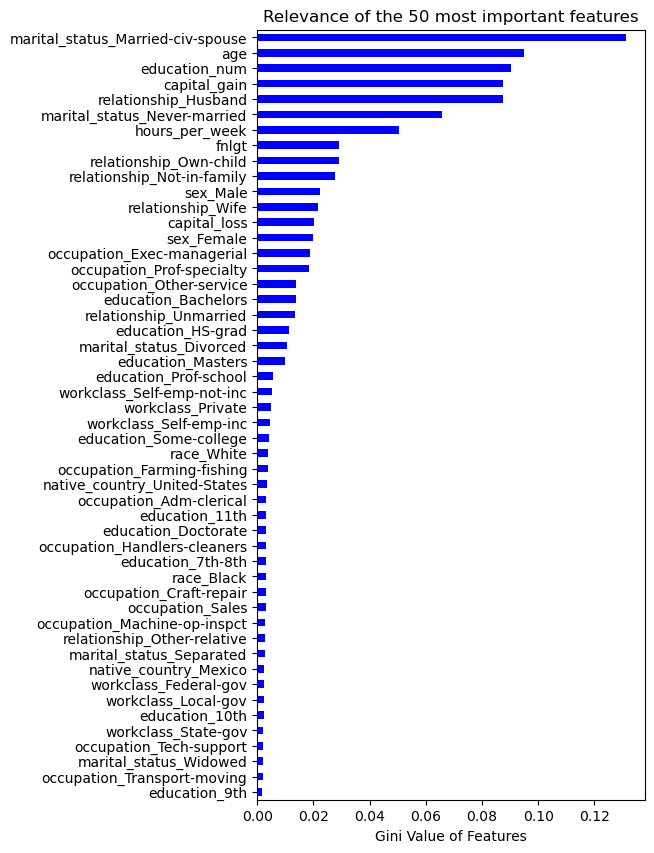

In [50]:
## Feature importances
importance = pd.DataFrame(model.feature_importances_.ravel())
importance.index = processing_parameters['final_feature_names']
importance.columns = ['coef']
importance['plus'] = importance['coef'].apply(lambda col: 1 if col > 0 else 0)
importance['coef'] = np.abs(importance['coef'])
# Plot top k coefficients
top_features = 50
plt.figure(figsize=(5,10))
importance.sort_values(by='coef',ascending=True,inplace=True)
color_list = ['b' if el > 0 else 'r' for el in [importance['plus'].iloc[i] for i in range(importance['plus'].shape[0])]]
importance['coef'][-top_features:].plot(kind='barh',color=color_list[-top_features:])
plt.xlabel('Gini Value of Features')
plt.title('Relevance of the 50 most important features')
plt.savefig('./assets/feature_importances.png',dpi=300,transparent=False,bbox_inches='tight')

### ROC Curve

In [52]:
df_train, df_test, config = cs.run_setup(config_filename='config.yaml', config=config)
X_test, y_test, processing_parameters = cs.run_processing(df_test,
                                                       config,
                                                       training=False,
                                                       processing_parameters=processing_parameters)

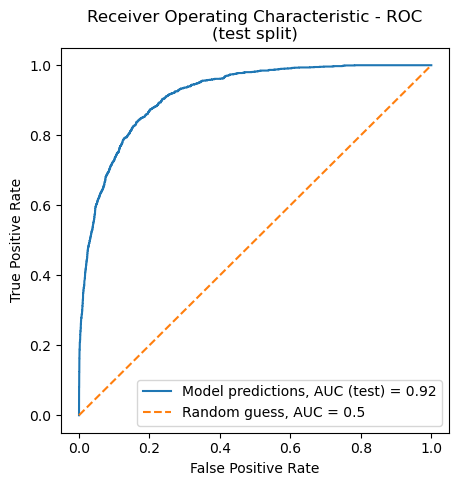

In [55]:
from sklearn.metrics import roc_curve

def plot_roc_curve(model, X_test, y_test, title, filename):
    """Plot ROC curve."""
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=None)
    plt.figure(figsize=(5,5))
    plt.title(f'Receiver Operating Characteristic - ROC\n({title})')
    plt.plot(fpr, tpr, label=f"Model predictions, AUC (test) = {round(auc,2)}")
    plt.plot([0, 1], ls="--", label="Random guess, AUC = 0.5")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.savefig(f'./assets/{filename}', dpi=200, transparent=False, bbox_inches='tight')

title = "test split"
filename = "model_roc_curve_test.png"
plot_roc_curve(model, X_test, y_test, title, filename)

## 6. Bias Analysis

In [59]:
import sys
!{sys.executable} -m pip install aequitas==0.42
#!{sys.executable} -m pip install aequitas==0.42 pandas==1.2.3

In [128]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

# Enable Pandas to display dataframes without restriction.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [181]:
# Re-Load the data and take an initial look at it.
df = pd.read_csv("./data/census.csv")

# IMPORTANT: We need to do that in production, too!
df = df.rename(columns={col_name: col_name.replace(' ', '') for col_name in df.columns})
df = df.rename(columns={col_name: col_name.replace('-', '_') for col_name in df.columns})

# Strip/remove the blank space in the categories
categorical_features = list(df.select_dtypes(include = ['object']))
for col in categorical_features:
    df[col] = df[col].str.replace(' ', '')

# Drop duplicates
# IMPORTANT: We need to do that in production, too!
df = df.drop_duplicates().reset_index(drop=True)

print(df.shape)
df.head()

(32537, 15)


,age,workclass,fnlgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32537 entries, 0 to 32536
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlgt           32537 non-null  int64 
 3   education       32537 non-null  object
 4   education_num   32537 non-null  int64 
 5   marital_status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital_gain    32537 non-null  int64 
 11  capital_loss    32537 non-null  int64 
 12  hours_per_week  32537 non-null  int64 
 13  native_country  32537 non-null  object
 14  salary          32537 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [183]:
# Predict salary (values already decoded)
# Store prediction scores
df['score'] = cs.predict(df.drop("salary", axis=1), model, processing_parameters)

# Replace scores
df['score'].replace({' <=50K':0, ' >50K':0}, inplace=True)
#print(df['salary'])

# Define label_value
df['label_value'] = df['salary']
df['label_value'].replace({' <=50K':0, ' >50K':0}, inplace=True)
df.drop('salary', axis=1, inplace=True)

In [185]:
df.head()

,age,workclass,fnlgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,score,label_value
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,0


In [186]:
from aequitas.preprocessing import preprocess_input_df

# Preprocess columns and dataset
categorical_cols = list(df.select_dtypes(include = ['object']))
numerical_cols = list(df.select_dtypes(include = ['float', 'int']))

# double-check that categorical columns are of type 'string'
for col in categorical_cols:
    df[col] = df[col].astype(str)
    
df, _ = preprocess_input_df(df)

In [187]:
num_cols_drop = ['age',
 'fnlgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']
df.drop(num_cols_drop, axis=1, inplace=True)

In [188]:
df.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,score,label_value
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,0,0
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,0,0
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,0,0
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,0,0
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,0,0


In [189]:
# We instantiate agroup class and
# create a crosstab: basis for all subsequent analyses
group = Group()
# We ignore the returned index variable with features
xtab, _ = group.get_crosstabs(df)

# The crosstab contains the data slicing statistics.
# For each categorical feature and each level/group in them
# we have a slice/group for which the statistics are computed.
# Check below the abbreviations of the statistics.
#xtab.head(10)
xtab.T

/Users/mxagar/opt/anaconda3/envs/census/lib/python3.8/site-packages/aequitas/group.py:182: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'score'] = df.loc[:,'score'].astype(float)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
model_id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
score_threshold,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1
k,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
attribute_name,workclass,workclass,workclass,workclass,workclass,workclass,workclass,workclass,workclass,education,education,education,education,education,education,education,education,education,education,education,education,education,education,education,education,marital_status,marital_status,marital_status,marital_status,marital_status,marital_status,marital_status,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,relationship,relationship,relationship,relationship,relationship,relationship,race,race,race,race,race,sex,sex,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country
attribute_value,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,Female,Male,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands,Honduras,Hong,Hungary,India,Iran,Ireland,I

In [190]:
# We instantiate a Bias class
# and compute disparities of the slices
# wrt. a reference group.
# We specify the reference group in ref_groups_dict.
# If we don't specify any reference group, the majority
# group/slice is taken.
# We get the same statistics as before + disparity statistics,
# differences wrt. refrence group
bias = Bias()
bias_df = bias.get_disparity_predefined_groups(xtab,
                                               original_df=df,
                                               ref_groups_dict={"workclass": df["workclass"].mode()[0],
                                                                "education": df["education"].mode()[0],
                                                                "marital_status": df["marital_status"].mode()[0],
                                                                "occupation": df["occupation"].mode()[0],
                                                                "relationship": df["relationship"].mode()[0],
                                                                "race": df["race"].mode()[0],
                                                                "sex": df["sex"].mode()[0],
                                                                "native_country": df["native_country"].mode()[0]
                                                                },
                                               alpha=0.05,
                                               mask_significance=True)
#bias_df.head(10)
bias_df.T

get_disparity_predefined_group()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
model_id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
score_threshold,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1
k,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
attribute_name,workclass,workclass,workclass,workclass,workclass,workclass,workclass,workclass,workclass,education,education,education,education,education,education,education,education,education,education,education,education,education,education,education,education,marital_status,marital_status,marital_status,marital_status,marital_status,marital_status,marital_status,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,relationship,relationship,relationship,relationship,relationship,relationship,race,race,race,race,race,sex,sex,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country
attribute_value,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,Female,Male,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands,Honduras,Hong,Hungary,India,Iran,Ireland,I

In [191]:
# If we don't specify any reference group, the majority
# group/slice is taken: African-Americal males 25-45 y.o.
bias.get_disparity_major_group(xtab,
                               original_df=df,
                               alpha=0.05,
                               mask_significance=True).T #head(10)

get_disparity_major_group()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
model_id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
score_threshold,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1
k,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
attribute_name,workclass,workclass,workclass,workclass,workclass,workclass,workclass,workclass,workclass,education,education,education,education,education,education,education,education,education,education,education,education,education,education,education,education,marital_status,marital_status,marital_status,marital_status,marital_status,marital_status,marital_status,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,relationship,relationship,relationship,relationship,relationship,relationship,race,race,race,race,race,sex,sex,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country
attribute_value,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,Female,Male,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands,Honduras,Hong,Hungary,India,Iran,Ireland,I

In [192]:
# The goal we have with Aequitas: Compute how fair the dataset is.
# We get the same statistics as before + Fairnes true/false parity values
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)
#fairness_df.head(10)
fairness_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
model_id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
score_threshold,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1
k,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
attribute_name,workclass,workclass,workclass,workclass,workclass,workclass,workclass,workclass,workclass,education,education,education,education,education,education,education,education,education,education,education,education,education,education,education,education,marital_status,marital_status,marital_status,marital_status,marital_status,marital_status,marital_status,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,occupation,relationship,relationship,relationship,relationship,relationship,relationship,race,race,race,race,race,sex,sex,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country,native_country
attribute_value,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,Female,Male,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands,Honduras,Hong,Hungary,India,Iran,Ireland,I

In [193]:
# We can get overall/summary values
# - Unsupervised fairness: composed by some of the metrics; if one is False, the value is False
# - Supervised fairness: composed by some of the metrics; if one is False, the value is False
# - Overall fairness
overall_fairness = fairness.get_overall_fairness(fairness_df)
print(overall_fairness)

{'Unsupervised Fairness': True, 'Supervised Fairness': True, 'Overall Fairness': True}


**I think the overall result/metric is wrong; apparently, data points are missing in many categories to perform a through evaluation.**

## 7. Test Deployed API

### API: Tests with Local Server

In [236]:
import requests
import json

In [239]:
r = requests.get("http://127.0.0.1:8000/")
print(r.text)

<html><body style='padding: 10px;'><h1>Welcome to the API</h1><div>Check the <a href='/docs'>documentation</a>.</div></body></html>


In [240]:
r = requests.get("http://127.0.0.1:8000/health")
print(r.json())

{'name': 'Census Salary Model API', 'api_version': '0.0.1', 'model_lib_version': '0.0.1'}


In [248]:
d = {
    "inputs": [
        {
            "age": 39,
            "workclass": "State-gov",
            "fnlgt": 77516,
            "education": "Bachelors",
            "education_num": 13,
            "marital_status": "Never-married",
            "occupation": "Adm-clerical",
            "relationship": "Not-in-family",
            "race": "White",
            "sex": "Male",
            "capital_gain": 2174,
            "capital_loss": 0,
            "hours_per_week": 40,
            "native_country": "United-States"
        }
    ]
}

In [249]:
r = requests.post("http://127.0.0.1:8000/predict", data=json.dumps(d))
print(r.json())

{'model_lib_version': '0.0.1', 'timestamp': '...', 'predictions': ['<=50K']}


### API: Tests with Deployed App (Heroku)